In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import linear_like, quad_like, log_like
linear, quad, log = linear_like(), quad_like(), log_like()

- Additional Bayesian term recovers correct parameters

- Same as least squares 

### Try on simple functions

In [3]:
def compare_bayes_ls(nk, theta_true, likelihood, mean_X, covinv_X, repeats=10):
    repeats = 10
    bs = np.zeros((repeats, len(theta_true)))
    ls = np.zeros((repeats, len(theta_true)))
    for i in range(repeats):
        Xs = generate_Xs(nk)
        y = likelihood.func(Xs, theta_true)
        bs[i] = minimise_bayes(y, likelihood, mean_X, covinv_X, theta_true).x
        ls[i] = minimise_ls(y, likelihood, mean_X, theta_true).x
    print(f"Bayes: {bs.mean(axis=0)} +/- {bs.std(axis=0)}")
    print(f"LS: {ls.mean(axis=0)} +/- {ls.std(axis=0)}")

def plot_bayes_ls(nk, theta_true, likelihood, mean_X, covinv_X):
    Xs = generate_Xs(nk)
    y = likelihood.func(Xs, theta_true)

    theta_bayes = minimise_bayes(y, likelihood, mean_X, covinv_X, theta_true).x
    theta_ls = minimise_ls(y, likelihood, mean_X, theta_true).x

    plt.plot(Xs, y, 'x', ms=2)
    plt.plot(Xs, likelihood.func(Xs, theta_bayes), label='bayes')
    plt.plot(Xs, likelihood.func(Xs, theta_ls), label='ls')
    plt.legend();
    print(f'bayes: {theta_bayes}')
    print(f'ls: {theta_ls}')
    return Xs, theta_bayes, theta_ls

In [4]:
nk = data_at_iteration(samples_g_1, 500)[0]
# nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

### Linear

In [6]:
compare_bayes_ls(nk, np.array([10]), linear, mean_X, covinv_X)

Bayes: [9.99987183] +/- [0.01790925]
LS: [10.01908652] +/- [0.12823091]


bayes: [10.00170898]
ls: [10.29582685]


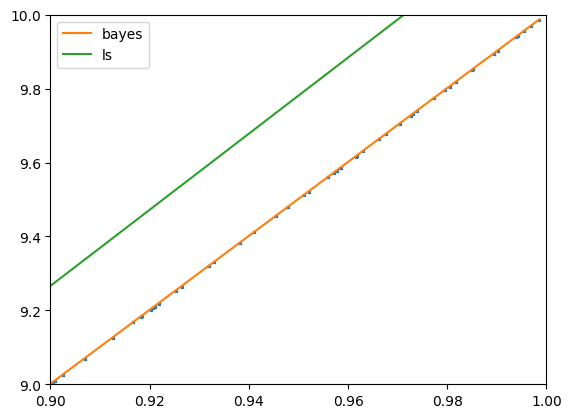

In [39]:
plot_bayes_ls(nk, 10, linear, mean_X, covinv_X)
plt.xlim(0.9, 1.0)
plt.ylim(9, 10);

gaussian: [10.05026551]
bayes: [10.01039105]


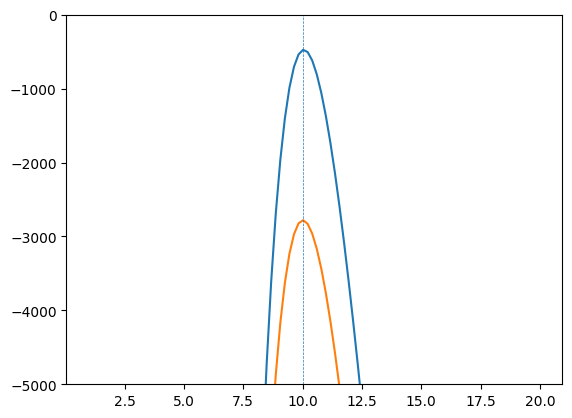

In [9]:
dtrue = 10
Xs = generate_Xs(nk)
y = linear.func(Xs, dtrue)

ds = np.linspace(1, 20, 100)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, linear, mean_X, covinv_X, d)
plt.plot(ds, logprs_gaussian)
print(f'gaussian: {minimise_gaussian(y, linear, mean_X, covinv_X, 10).x}')

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, linear, mean_X, covinv_X, d)
plt.plot(ds, logprs_bayes)
print(f'bayes: {minimise_bayes(y, linear, mean_X, covinv_X, 10).x}')
plt.axvline(x=10, ls='--', lw=.5)
plt.ylim(-5000, 0);

### Quadratic

In [23]:
compare_bayes_ls(nk, np.array([10]), quad, mean_X, covinv_X)

Bayes: [10.00563965] +/- [0.02637992]
LS: [9.98298001] +/- [0.21687897]


bayes: [10.02746582]
ls: [10.26088883]


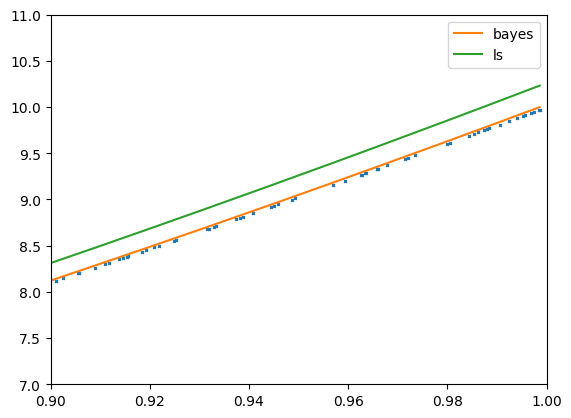

In [36]:
plot_bayes_ls(nk, 10, quad, mean_X, covinv_X)
plt.xlim(0.9, 1.0)
plt.ylim(7, 11);

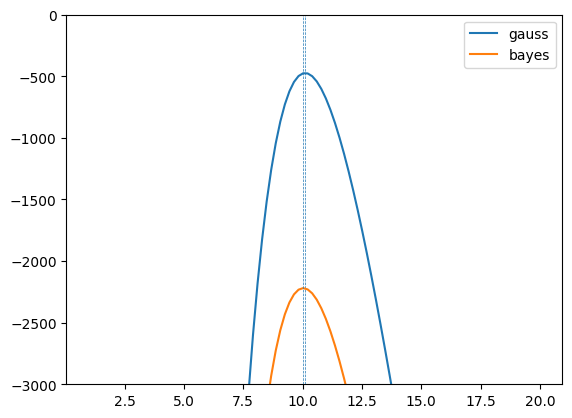

In [13]:
dtrue = 10
Xs = generate_Xs(nk)
y = quad.func(Xs, dtrue)

ds = np.linspace(1, 20, 100)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, quad, mean_X, covinv_X, d)
d_gauss = minimise_gaussian(y, quad, mean_X, covinv_X, 10).x

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, quad, mean_X, covinv_X, d)
d_bayes = minimise_bayes(y, quad, mean_X, covinv_X, 10).x

plt.plot(ds, logprs_gaussian, label='gauss')
plt.axvline(x=d_gauss, ls='--', lw=.5)
plt.plot(ds, logprs_bayes, label='bayes')
plt.axvline(x=d_bayes, ls='--', lw=.5)
plt.ylim(-3000, 0);
plt.legend();

### Log

In [46]:
compare_bayes_ls(nk, np.array([10]), log, mean_X, covinv_X, repeats=100)

Bayes: [9.80037231] +/- [0.37692574]
LS: [9.8078813] +/- [0.27656211]


bayes: [9.92181396]
ls: [9.76235994]


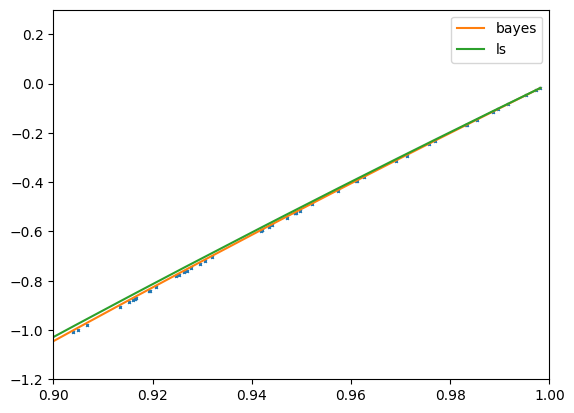

In [43]:
plot_bayes_ls(nk, 10, log, mean_X, covinv_X)
plt.xlim(0.9, 1)
plt.ylim(-1.2, 0.3);

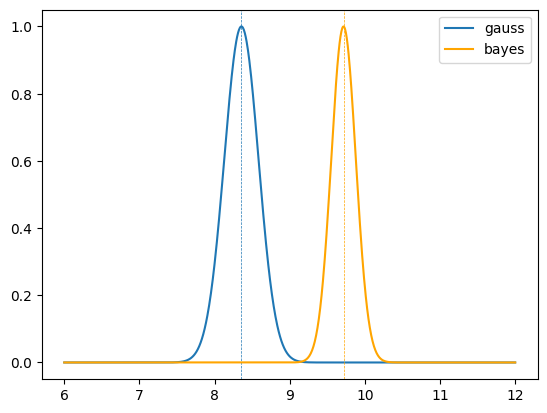

In [83]:
dtrue = 10
Xs = generate_Xs(nk)
y = log.func(Xs, dtrue)
d_ls = minimise_ls(y, log, mean_X, dtrue).x

ds = np.linspace(6, 12, 1000)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, log, mean_X, covinv_X, d)
d_gauss = minimise_gaussian(y, log, mean_X, covinv_X, 10).x

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, log, mean_X, covinv_X, d)
d_bayes = minimise_bayes(y, log, mean_X, covinv_X, 10).x

plt.plot(ds, np.exp(logprs_gaussian - logprs_gaussian.max()), label='gauss')
plt.axvline(x=d_gauss, ls='--', lw=.5)
plt.plot(ds, np.exp(logprs_bayes - logprs_bayes.max()), label='bayes', color='orange')
plt.axvline(x=d_bayes, ls='--', lw=.5, color='orange')
plt.legend();

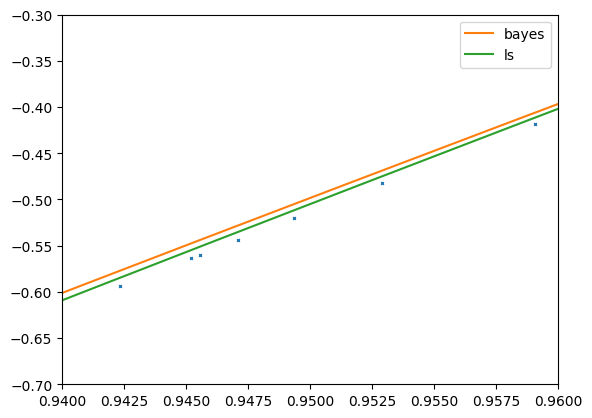

In [84]:
plt.plot(Xs, y, 'x', ms=2)
plt.plot(log.inverse(y, d_bayes), y, label='bayes')
plt.plot(log.inverse(y, d_ls), y, label='ls')
plt.xlim(0.94, 0.96)
plt.ylim(-0.7, -0.3);
plt.legend();